In [1]:
#pip install pandas scikit-learn matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

students = pd.read_csv('/kaggle/input/studentdata1/students.csv')
courses = pd.read_csv('/kaggle/input/studentdata1/courses.csv')
grades = pd.read_csv('/kaggle/input/studentdata1/grades.csv')


In [3]:
students.head(3)

,studentId,name,cgpa,age,gender,attendance,academicStanding
0,318,Student318,2.29,22,Male,87.2,Probationary
1,425,Student425,3.34,21,Male,96.4,Good Standing
2,715,Student715,2.50,18,Male,86.7,Probationary


In [4]:
grades.head(2)

,studentId,courseId,grade,semester,department
0,318,CSE101,3.05,Fall 2023,Computer Science
1,318,MAT101,2.33,Fall 2023,Mathematics


In [5]:
courses.head()

,courseId,title,credit,difficulty,semester,department
0,CSE101,Intro to CS,3.0,Medium,Fall 2023,Computer Science
1,CSE102,Data Structures,3.0,Hard,Spring 2024,Computer Science
2,MAT101,Calculus I,4.0,Hard,Fall 2023,Mathematics
3,ENG201,Advanced Writing,2.0,Easy,Spring 2024,Humanities


In [6]:
#Merge datsets
merged_data = pd.merge(
    students, 
    grades, 
    on='studentId', 
    suffixes=('_student', '_grade')
)

full_data = pd.merge(
    merged_data, 
    courses, 
    on='courseId', 
    suffixes=('', '_course')
)

full_data = full_data.rename(columns={'semester': 'enrollment_semester'})

print("Columns in full_data:", full_data.columns.tolist())

Columns in full_data: ['studentId', 'name', 'cgpa', 'age', 'gender', 'attendance', 'academicStanding', 'courseId', 'grade', 'enrollment_semester', 'department', 'title', 'credit', 'difficulty', 'semester_course', 'department_course']


In [7]:
print("Dataset Overview:")
print(f"Total Students: {students['studentId'].nunique()}")
print(f"Total Courses: {courses['courseId'].nunique()}")
print(f"Total Grade Records: {len(grades)}\n")

print("First 5 Rows of Merged Data:")
print(full_data.head())



Dataset Overview:
Total Students: 100
Total Courses: 4
Total Grade Records: 400

First 5 Rows of Merged Data:
   studentId        name  cgpa  age gender  attendance academicStanding  \
0        318  Student318  2.29   22   Male        87.2     Probationary   
1        318  Student318  2.29   22   Male        87.2     Probationary   
2        318  Student318  2.29   22   Male        87.2     Probationary   
3        318  Student318  2.29   22   Male        87.2     Probationary   
4        425  Student425  3.34   21   Male        96.4    Good Standing   

  courseId  grade enrollment_semester        department             title  \
0   CSE101   3.05           Fall 2023  Computer Science       Intro to CS   
1   MAT101   2.33           Fall 2023       Mathematics        Calculus I   
2   ENG201   3.53         Spring 2024        Humanities  Advanced Writing   
3   CSE102   2.51         Spring 2024  Computer Science   Data Structures   
4   MAT101   3.08           Fall 2023       Mathematic

# Feature Engineering

In [8]:
#string to numerical
semester_order = {
    'Fall 2023': 1,
    'Spring 2024': 2,
    'Fall 2024': 3
}

full_data['semester_num'] = full_data['enrollment_semester'].map(semester_order)

full_data['credit_load'] = full_data.groupby(
    ['studentId', 'enrollment_semester']
)['credit'].transform('sum')

standing_order = {
    'Academic Warning': 0,
    'Probationary': 1,
    'Good Standing': 2,
    "Dean's List": 3
}
full_data['standing_code'] = full_data['academicStanding'].map(standing_order)

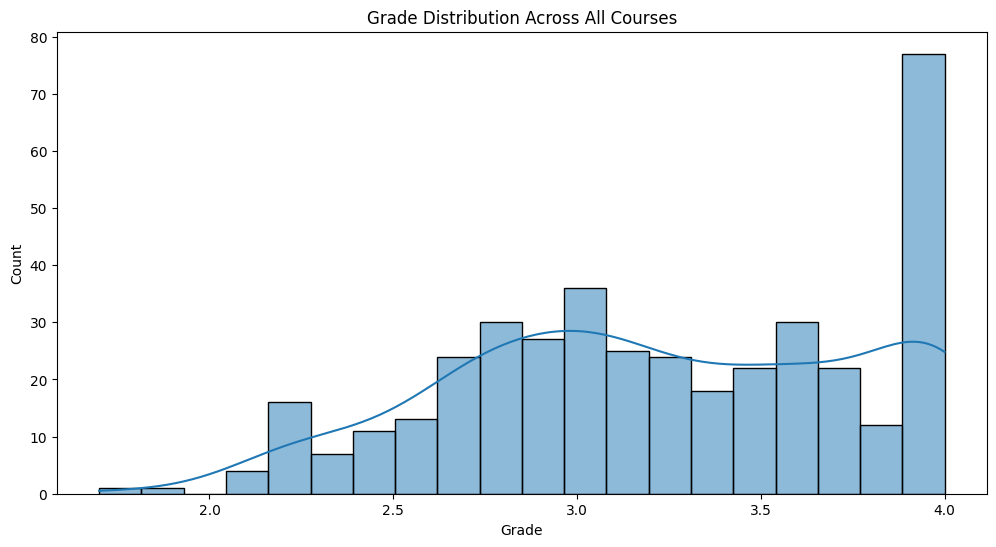

In [9]:
plt.figure(figsize=(12, 6))
sns.histplot(full_data['grade'], bins=20, kde=True)
plt.title('Grade Distribution Across All Courses')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.show()



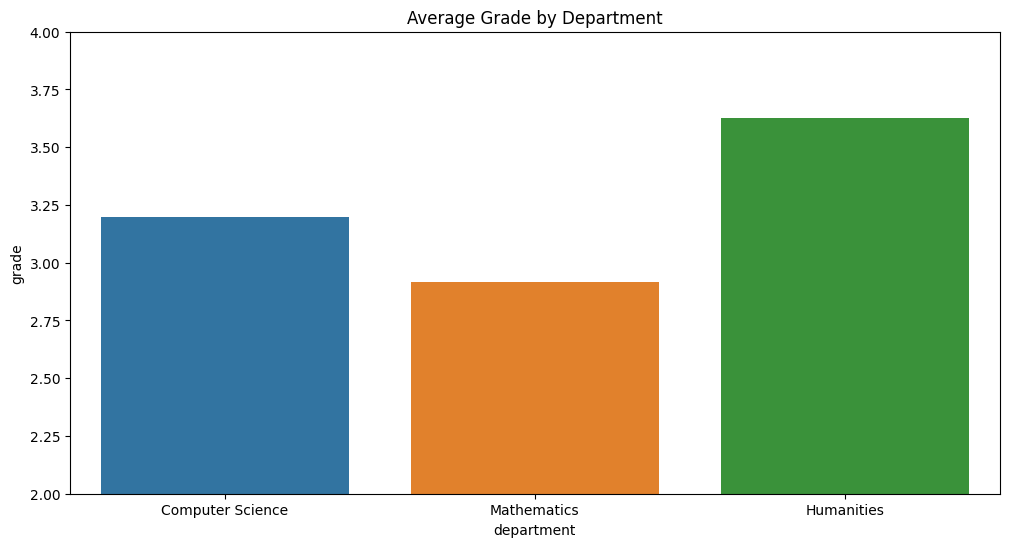

In [10]:
plt.figure(figsize=(12, 6))
sns.barplot(x='department', y='grade', data=full_data, estimator=np.mean, ci=None)
plt.title('Average Grade by Department')
plt.ylim(2.0, 4.0)
plt.show()



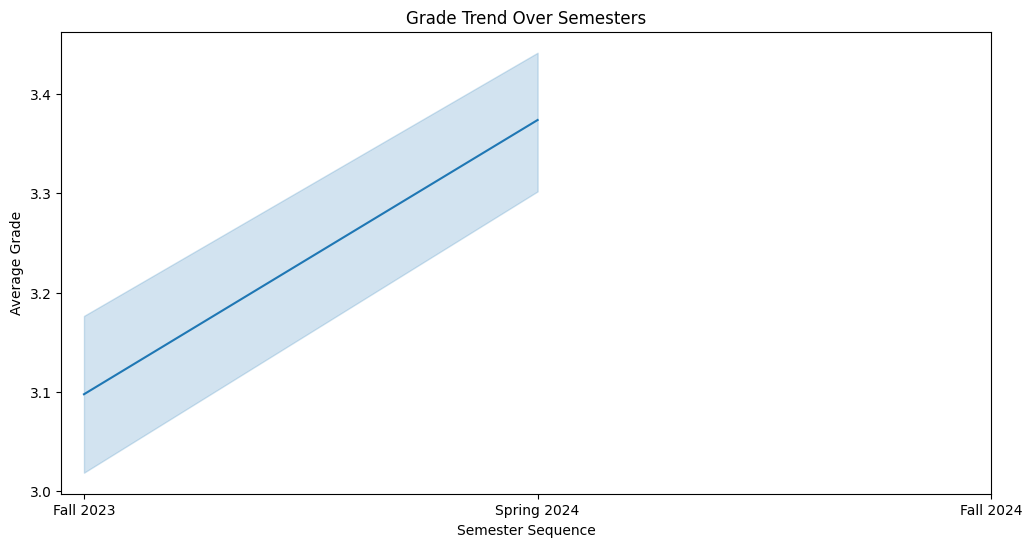

In [11]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='semester_num', y='grade', data=full_data, estimator=np.mean)
plt.title('Grade Trend Over Semesters')
plt.xlabel('Semester Sequence')
plt.ylabel('Average Grade')
plt.xticks(ticks=[1, 2, 3], labels=['Fall 2023', 'Spring 2024', 'Fall 2024'])
plt.show()


# Prepareing data for ML

In [12]:
#define features and target
features = full_data[['cgpa', 'attendance', 'age', 'credit', 'difficulty', 
                     'department', 'standing_code', 'credit_load']]
target = full_data['grade']

#split
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)


In [13]:
#how to handle numeric and categorical values
numeric_features = ['cgpa', 'attendance', 'age', 'credit', 'standing_code', 'credit_load']
categorical_features = ['difficulty', 'department']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


# Model Trainign

In [14]:
#pipeline for the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        max_depth=8,
        min_samples_leaf=4,
        random_state=42
    ))
])


#Training
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['cgpa', 'attendance', 'age',
                                                   'credit', 'standing_code',
                                                   'credit_load']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['difficulty',
                                                   'department'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=8, min_samples_leaf=4,
                                       n_estimators=200, random_state=42))])

# Evalutaion

In [15]:
#make predictiong
y_pred = model.predict(X_test)

print("\nModel Performance:")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")




Model Performance:
RMSE: 0.1727
R² Score: 0.9029



Sample of Model Predictions on Test Data:
     Actual Grade  Predicted Grade
209          4.00         3.754129
280          3.75         3.732330
33           3.04         3.003652
210          4.00         3.957471
93           3.85         3.807080
84           3.55         3.521290
329          2.34         2.295078
94           3.73         3.650421
266          2.93         2.771251
126          2.47         2.294649


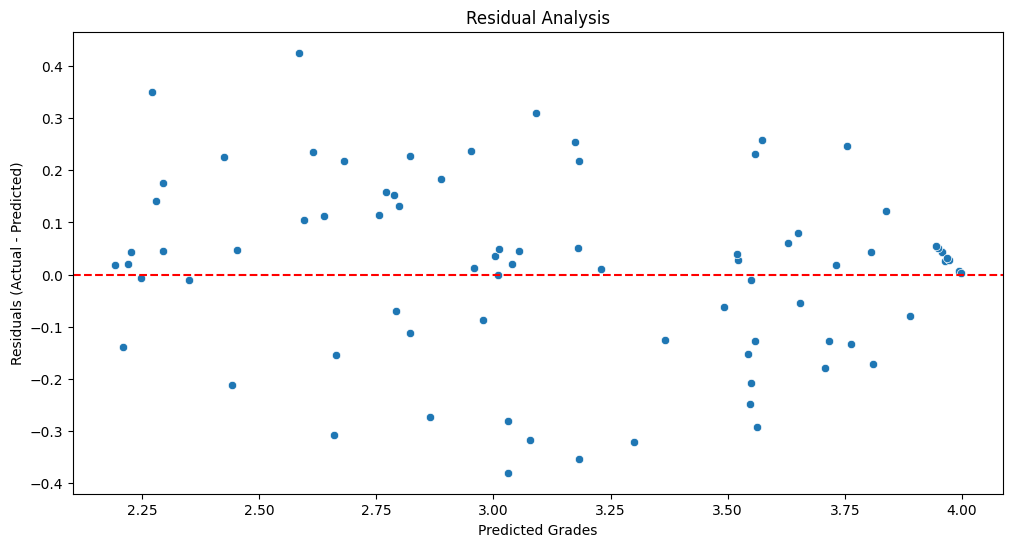

In [16]:
predictions_df = pd.DataFrame({'Actual Grade': y_test, 'Predicted Grade': y_pred})
print("\nSample of Model Predictions on Test Data:")
print(predictions_df.head(10))  

residuals = y_test - y_pred

plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Analysis')
plt.xlabel('Predicted Grades')
plt.ylabel('Residuals (Actual - Predicted)')
plt.show()

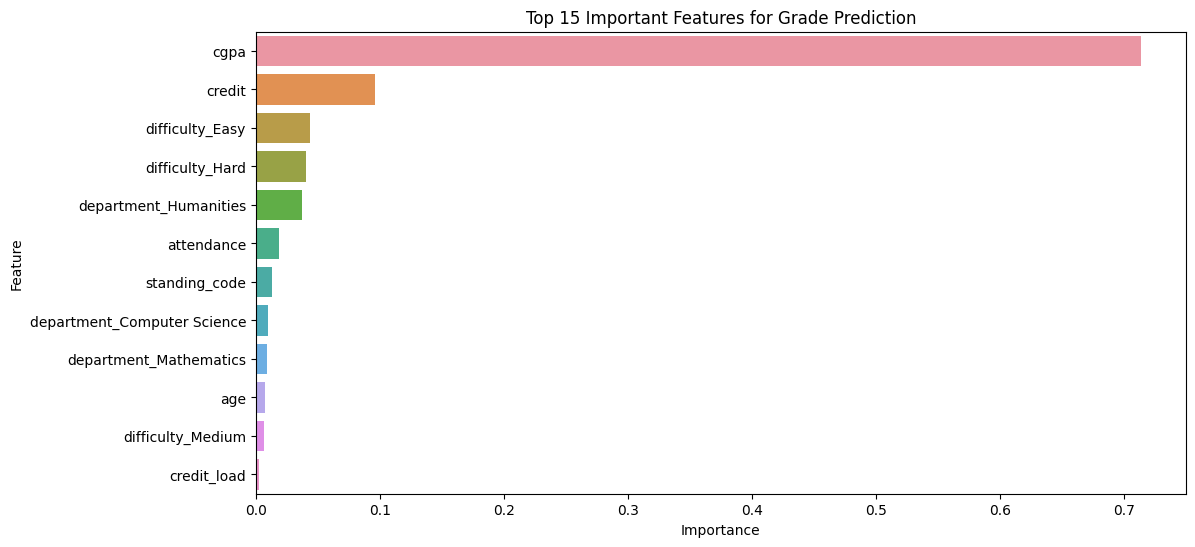

In [17]:
#Feature Importance Analysis
feature_names = numeric_features + list(
    model.named_steps['preprocessor'].named_transformers_['cat']
    .get_feature_names_out(categorical_features)
)

importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model.named_steps['regressor'].feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importances.head(15))
plt.title('Top 15 Important Features for Grade Prediction')
plt.show()

